In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sys import path
path.append('../tools')
from tools import logsig

In [12]:
def get_expected_output(X):
    return logsig(np.dot(logsig(X * np.array([10, 10]) + np.array([-5, 5])), np.array([1, 1])) + -1)

In [13]:
vec_get_y = np.vectorize(get_expected_output)

In [14]:
x_train = np.linspace(-2, 2, 82)
y_train = vec_get_y(x_train)

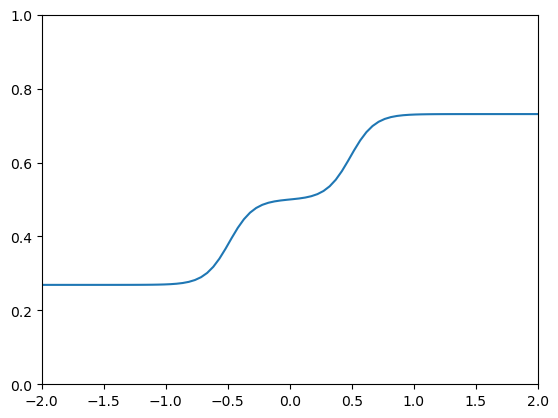

In [15]:
plt.xlim(-2, 2)
plt.ylim(0, 1)
plt.plot(x_train, y_train)

In [16]:
x_train = x_train.reshape(len(x_train), 1)
y_train = y_train.reshape(len(y_train), 1)
print(x_train, y_train)

[[-2.        ]
 [-1.95061728]
 [-1.90123457]
 [-1.85185185]
 [-1.80246914]
 [-1.75308642]
 [-1.7037037 ]
 [-1.65432099]
 [-1.60493827]
 [-1.55555556]
 [-1.50617284]
 [-1.45679012]
 [-1.40740741]
 [-1.35802469]
 [-1.30864198]
 [-1.25925926]
 [-1.20987654]
 [-1.16049383]
 [-1.11111111]
 [-1.0617284 ]
 [-1.01234568]
 [-0.96296296]
 [-0.91358025]
 [-0.86419753]
 [-0.81481481]
 [-0.7654321 ]
 [-0.71604938]
 [-0.66666667]
 [-0.61728395]
 [-0.56790123]
 [-0.51851852]
 [-0.4691358 ]
 [-0.41975309]
 [-0.37037037]
 [-0.32098765]
 [-0.27160494]
 [-0.22222222]
 [-0.17283951]
 [-0.12345679]
 [-0.07407407]
 [-0.02469136]
 [ 0.02469136]
 [ 0.07407407]
 [ 0.12345679]
 [ 0.17283951]
 [ 0.22222222]
 [ 0.27160494]
 [ 0.32098765]
 [ 0.37037037]
 [ 0.41975309]
 [ 0.4691358 ]
 [ 0.51851852]
 [ 0.56790123]
 [ 0.61728395]
 [ 0.66666667]
 [ 0.71604938]
 [ 0.7654321 ]
 [ 0.81481481]
 [ 0.86419753]
 [ 0.91358025]
 [ 0.96296296]
 [ 1.01234568]
 [ 1.0617284 ]
 [ 1.11111111]
 [ 1.16049383]
 [ 1.20987654]
 [ 1.25925

In [19]:
# Create the model with keras and tensorflow
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import layers

class ConjugateGradientModel(keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = keras.losses.MeanSquaredError()
    
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compute_loss(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply(gradients, trainable_vars)

        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [20]:
inputs = keras.Input(shape=(1,), name='InputLayer')
x = layers.Dense(2, activation='sigmoid', name='LogSig1')(inputs)
outputs = layers.Dense(1, activation='sigmoid', name='LogSig2')(x)

model = ConjugateGradientModel(inputs, outputs)
model.compile(optimizer='SGD', loss='mse', metrics=['accuracy', 'mse'])

model.fit(x_train, y_train, epochs=1)

AttributeError: in user code:

    C:\Users\redbi\.conda\envs\tensorflow25\lib\site-packages\keras\engine\training.py:830 train_function  *
        return step_function(self, iterator)
    C:\Users\redbi\.conda\envs\tensorflow25\lib\site-packages\keras\engine\training.py:813 run_step  *
        outputs = model.train_step(data)
    C:\Users\redbi\AppData\Local\Temp\ipykernel_18904\3163283831.py:24 train_step  *
        loss = self.compute_loss(y, y_pred)

    AttributeError: 'ConjugateGradientModel' object has no attribute 'compute_loss'
